# Custom version of Stable Diffusion

In [1]:
!pip install transformers diffusers ftfy accelerate

  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Using cached diffusers-0.7.0-py3-none-any.whl (305 kB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached accelerate-0.13.2-py3-none-any.whl (148 kB)
  Using cached tokenizers-0.13.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import math

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.18.mlp.fc2.weight', 'vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.layer_norm2.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.14.layer_norm1.bias', 'visio

In [6]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [7]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

## Methods

In [8]:
def make_text_embs(image_prompt, negative_prompt=""): 
    token_info = tokenizer([image_prompt], padding="max_length", truncation=True, return_tensors="pt")
    token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
    
     # make text_embs
    uncond_info = tokenizer([negative_prompt], padding="max_length", truncation=True, return_tensors="pt")
    uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
    text_embs = torch.cat([uncond_embs, token_embs])
    return text_embs

In [9]:
def gen_image(text_embs, height=512, width=512, steps=50, gd=7.5, seed=100, get_all=False, return_preview=False, latents=None, start_step=0):
    torch.manual_seed(seed)
    
    if latents == None or start_step == 0:
        latents = torch.randn(len(text_embs)//2, unet.in_channels, height // 8, width // 8).to("cuda").half()
        latents = latents * scheduler.init_noise_sigma
    else:
        t = scheduler.timesteps[start_step-2]
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad():
            pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + gd * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        latents = scheduler.step(pred, t, latents).prev_sample

    scheduler.set_timesteps(steps)
    latents_list = []
    
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if start_step > i:
            continue
            
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + gd * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        updated_info = scheduler.step(pred, t, latents)
        latents = updated_info.prev_sample
        
        if get_all:
            latents_list.append(updated_info.pred_original_sample if return_preview else latents)
    
    if get_all:
        return latents_list
    
    return latents

In [10]:
def decode_latents(latents, scale_factor=1.0, to_tensor=False):
    with torch.no_grad():
        im_data = vae.decode(latents * 1 / 0.18215).sample[0]
    
    norm_im_data = (im_data * 0.5 + 0.5).clamp(0, 1)
    
    if to_tensor:
        return norm_im_data
    
    rgb_im_data = (norm_im_data * 255).permute(1, 2, 0).cpu().numpy().round().astype("uint8")
    im = Image.fromarray(rgb_im_data)
    
    return im.resize(((int)(im.width * scale_factor), (int)(im.height * scale_factor)))

In [11]:
def show_latents_grid(latents_list, cols=8, scale_factor=1.0):
    images = [decode_latents(item, scale_factor) for item in latents_list]
    
    w,h = images[0].size
    rows = math.ceil(len(images) / cols)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(images): 
        grid.paste(img, box=(i%cols*w, i//cols*h))
        
    return grid

In [12]:
def load_image(img_path, size=(512, 512), to_tensor=False):
    im = Image.open(img_path).convert("RGB").resize(size)
    
    if to_tensor:
        return transforms.ToTensor()(im)
    
    return im

In [13]:
def encode_latents(img, scale_factor=1.0):
    tensor_img = transforms.ToTensor()(img).half()
    tensor_img = (tensor_img * 2.0) - 1.0
    
    with torch.no_grad():
        encoded = vae.encode(tensor_img.unsqueeze(0).to(vae.device))
        latents = 0.18215 * encoded.latent_dist.sample()
        
        return latents

In [14]:
def image_to_noise(img, total_steps, noise_step, seed=100):
    latents = encode_latents(img)
    torch.manual_seed(seed)
    noise = torch.randn_like(latents)
    scheduler.set_timesteps(total_steps)
    latents = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[noise_step]]))
    
    return latents

In [15]:
def image_to_noise_and_text(text_embs, img, total_steps=50, noise_step=24, gd=7.5, seed=100):
    torch.manual_seed(seed)
    
    latents = image_to_noise(img, total_steps=total_steps, noise_step=noise_step,seed=seed)
    
    scheduler.set_timesteps(total_steps)

    updated_info = 0
    
    # predict the noise residual
    with torch.no_grad():
        for i in range(1):
            t = scheduler.timesteps[noise_step-1 + i]
            input = torch.cat([latents] * 2)
            input = scheduler.scale_model_input(input, t)
            pred = unet(input, t, encoder_hidden_states=text_embs).sample

            # perform guidance
            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + gd * (pred_text - pred_uncond)

            # compute the "previous" noisy sample
            updated_info = scheduler.step(pred, t, latents)
            latents = updated_info.prev_sample
    
    return updated_info.pred_original_sample

### Usage

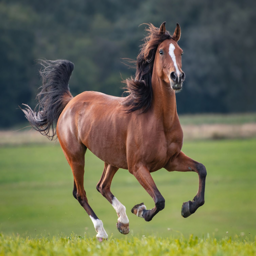

In [428]:
im_horse = load_image("./images/horse.png")
im_horse.resize((256, 256))

### Playing with Latents & Text Embs

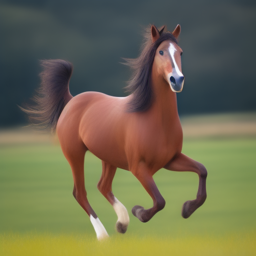

In [429]:
prompt = "a horse"
latents = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=31)
decode_latents(latents, scale_factor=0.5)

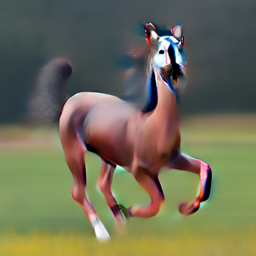

In [430]:
prompt = "a cat"
latents = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=24)
decode_latents(latents, scale_factor=0.5)

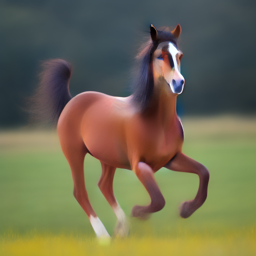

In [431]:
prompt = "a horse"
latents = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=24)
decode_latents(latents, scale_factor=0.5)

  0%|          | 0/8 [00:00<?, ?it/s]

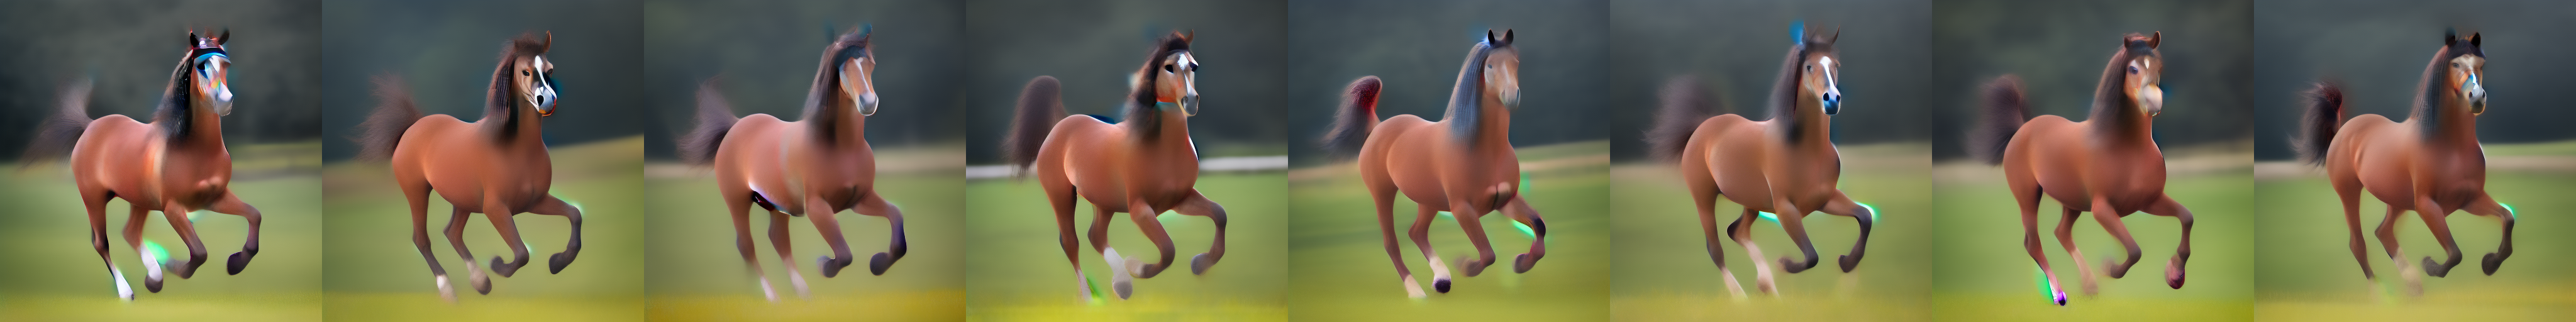

In [433]:
prompt = "a horse"
horse_latents_list = []
for i in tqdm(range(8)):
    lt = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=24, seed=i*1000//1)
    horse_latents_list.append(lt)
    
show_latents_grid(horse_latents_list, cols=8)

  0%|          | 0/8 [00:00<?, ?it/s]

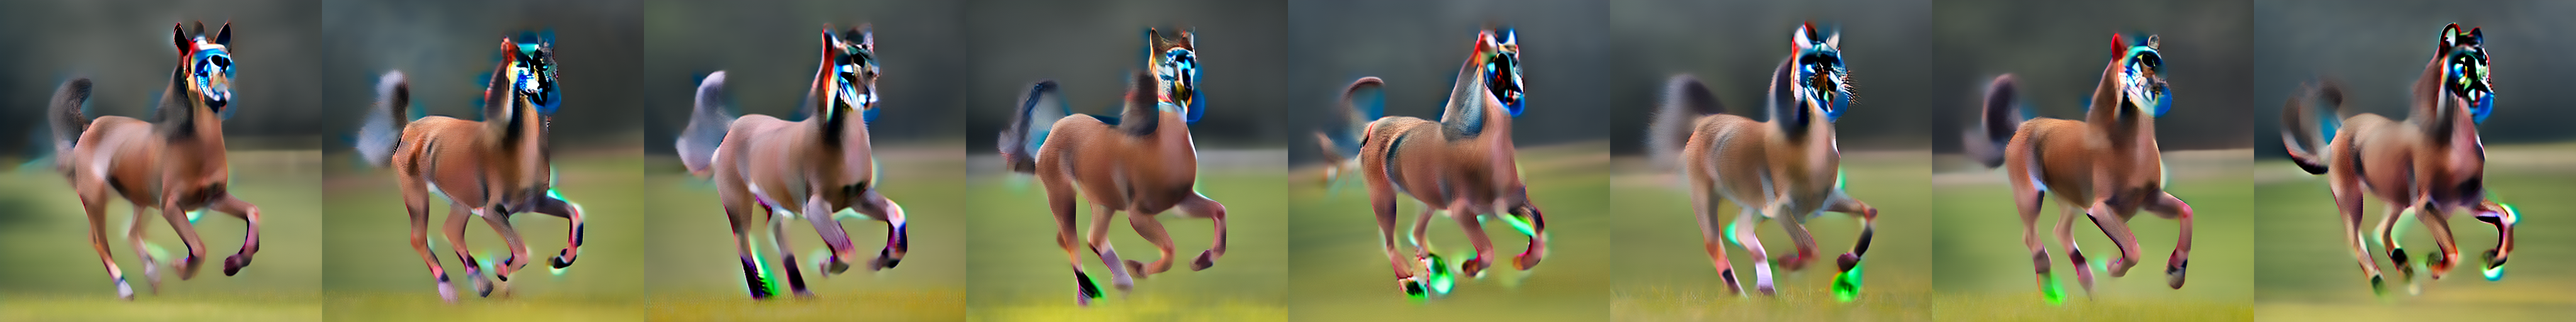

In [434]:
prompt = "a cat"
horse_latents_list = []
for i in tqdm(range(8)):
    lt = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=24, seed=i*1000//1)
    horse_latents_list.append(lt)
    
show_latents_grid(horse_latents_list, cols=8)

In [435]:
prompt = "a horse"
latents = image_to_noise_and_text(make_text_embs(prompt), im_horse, total_steps=50, noise_step=31)
im_tensor = decode_latents(latents, scale_factor=0.5, to_tensor=True)

In [436]:
ref_prompt = "a horse"
other_prompt = "a zeebra"

ref = 0;
diff_list = [];

for i in tqdm(range(20)):
    seed = i*1000//1
    lt_ref = image_to_noise_and_text(make_text_embs(ref_prompt), im_horse, total_steps=50, noise_step=24, seed=seed)
    lt_other = image_to_noise_and_text(make_text_embs(other_prompt), im_horse, total_steps=50, noise_step=24, seed=seed)
    
    img_ref = decode_latents(lt_ref, to_tensor=True)
    img_other = decode_latents(lt_other, to_tensor=True)
    
    diff_list.append(img_ref.mean(dim=0) - img_other.mean(dim=0))
    #diff_list.append(decode_latents(lt_ref - lt_other, to_tensor=True))


  0%|          | 0/20 [00:00<?, ?it/s]

In [437]:
def normlize_image(image_tensor):
    return (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())

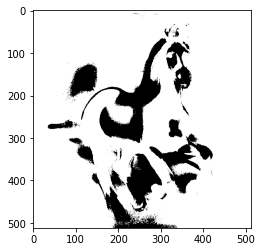

In [439]:
norm_diff = normlize_image(torch.stack(diff_list).mean(dim=0))
mask = (norm_diff >= 0.45).float()
mask = mask.cpu()
plt.imshow(mask, cmap="Greys")

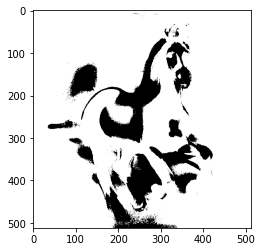

In [440]:
plt.imsave('./images/mask.jpeg', mask, cmap='Greys')
plt.imshow(mask, cmap='Greys')

In [404]:
import cv2

def improve_mask(p, mask):
    ## load image
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ## Adapative threshold
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 0)

    # Perform morphology
    se = np.ones((0,0), dtype='uint8')
    image_close = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se)
    image_close = abs(image_close - 255)
    
    
    ## mix morph + image mask
    nmask = np.minimum(1.0,mask + image_close)
    nmask = abs(nmask - 255)
    
    ## adding the blur+clip trick
    nmask = abs((abs(cv2.blur(nmask, (10, 10)) - 255) > 0) * 255 - 255)
    
    return nmask

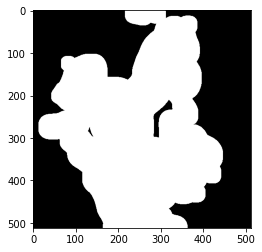

In [441]:
mask2 = improve_mask('./images/mask.jpeg', mask.numpy())
plt.imsave('./images/mask2.jpeg', mask2, cmap='Greys')
plt.imshow(mask2, cmap="Greys")